In [1]:
import scipy.io
import matplotlib.image as mimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pprint
tf.compat.v1.disable_eager_execution()

[[<br/>
    *(array([layer-name], dtype = '<U7')),<br/>
    *(array([layer], dtype = '<U4')),<br/>
    <br/>
    <br/>
    array([<br/>
        array[W],<br/>
        array[b],<br/>
        array[shape],<br/>,
        array[stride]<br/>,
        ...<br/>
        ...<br/>
    ])<br/>
]]<br/>


In [2]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']


    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]

        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]

        assert layer_name == expected_layer_name
        return W,b,


    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer , layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b,b.size))
        return tf.nn.conv2d(prev_layer, W, strides = [1,1,1,1], padding = "SAME" ) + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))


    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = "SAME")

    graph = {}
    graph['input'] = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')
    graph['conv1_1'] = _conv2d_relu(graph['input'], 0 , 'conv1_1')
    graph['conv1_2'] = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])

    graph['conv2_1'] = _conv2d_relu(graph['avgpool1'], 5 , 'conv2_1')
    graph['conv2_2'] = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])

    graph['conv3_1'] = _conv2d_relu(graph['avgpool2'], 10 , 'conv3_1')
    graph['conv3_2'] = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3'] = _conv2d_relu(graph['conv3_2'], 14 , 'conv3_3')
    graph['conv3_4'] = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])

    graph['conv4_1'] = _conv2d_relu(graph['avgpool3'], 19 , 'conv4_1')
    graph['conv4_2'] = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3'] = _conv2d_relu(graph['conv4_2'], 23 , 'conv4_3')
    graph['conv4_4'] = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])

    graph['conv5_1'] = _conv2d_relu(graph['avgpool4'], 28 , 'conv5_1')
    graph['conv5_2'] = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3'] = _conv2d_relu(graph['conv5_2'], 32 , 'conv5_3')
    graph['conv5_4'] = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])

    return graph

    

In [3]:
pp = pprint.PrettyPrinter(indent = 4)
with tf.device("cpu:0"):
    model = load_vgg_model('helper/imagenet-vgg-verydeep-19.mat')
print(type(model))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<class 'dict'>


# Content Cost

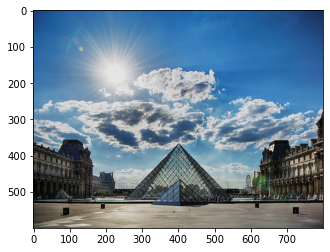

In [4]:
content_image = mimg.imread('helper/images/louvre.jpg')
plt.imshow(content_image)

In [5]:
def compute_content_cost(a_c, a_g):
    m, n_h, n_w, n_c  = a_g.get_shape().as_list()

    a_c_unrolled = tf.reshape(a_c , [m, n_h * n_w, n_c])
    a_g_unrolled = tf.reshape(a_g, [m , -1, n_c])

    J_content = (1/(4 * n_h *n_w * n_c))*  tf.reduce_sum(tf.square(tf.subtract(a_c_unrolled, a_g_unrolled)))

    return J_content

In [6]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_c  = tf.compat.v1.random_normal([1,4,4,3], mean = 1 , stddev = 4)
    a_g  = tf.compat.v1.random_normal([1,4,4,3], mean = 1, stddev = 4)

    J_content = compute_content_cost(a_c, a_g)
    print(f"J_content = {str(J_content.eval())}")

J_content = 6.7655935


# Style Cost

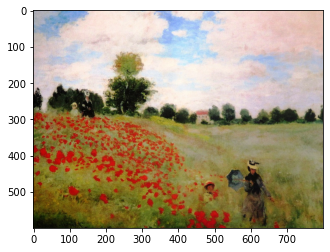

In [7]:
style_image = mimg.imread('helper/images/monet_800600.jpg')
plt.imshow(style_image)

In [8]:
def gram_matrix(A):
    gram = tf.matmul(A, tf.transpose(A))
    return gram

In [9]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    A = tf.compat.v1.random_normal([3, 2*1], mean = 1, stddev = 4)
    gram = gram_matrix(A)
    print(f"Gram Matrix = {str(gram.eval())}")

Gram Matrix = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [10]:
def compute_layer_cost(a_s, a_g):
    m, n_h , n_w, n_c  = a_g.get_shape().as_list()

    a_s = tf.transpose(tf.reshape(a_s, [n_h * n_w, n_c]))
    a_g = tf.transpose(tf.reshape(a_g, [n_h * n_w, n_c]))

    a_s = gram_matrix(a_s)
    a_g = gram_matrix(a_g)

    J = (1/ (4 *(n_h  * n_w * n_c)**2)) * tf.reduce_sum(tf.square(tf.subtract(a_s, a_g)))

    return J

In [11]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    tf.compat.v1.set_random_seed(1)
    a_s = tf.compat.v1.random_normal([1,4,4,3], mean = 1, stddev = 4)
    a_g = tf.compat.v1.random_normal([1,4,4,3], mean = 1, stddev = 4)
    J_style = compute_layer_cost(a_s, a_g)

    print(f"J_style cost  = {str(J_style.eval())}")

J_style cost  = 9.190279



### Style Weights

In [12]:
style_layers = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2) 
]

In [13]:
def compute_style_cost(model , style_layer):
    J_style = 0
    
    for layer_name, coefficient in style_layer:
        
        out = model[layer_name]

        a_s = sess.run(out)
        a_g = out

        J_style_layer = compute_layer_cost(a_s, a_g)
        J_style += coefficient * J_style_layer

    return J_style


# Total Cost

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = 0
    J = alpha * J_content + beta * J_style
    return J

In [15]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as test:
    np.random.seed(3)

    J_content = np.random.randn()
    J_style = np.random.randn()

    J = total_cost(J_content, J_style)
    print(f"Total Cost = {str(J)}")

Total Cost = 35.34667875478276


# Optimization Objective

In [29]:
import pandas as pd
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):

    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imshow(image)
    plt.savefig(path)

### Start the interactive session

In [30]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

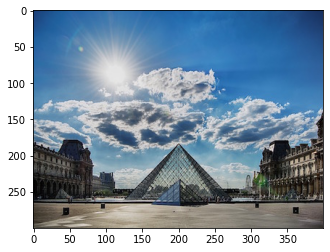

In [31]:
content_image = mimg.imread('helper/images/louvre_small.jpg')
plt.imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

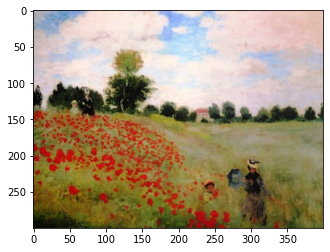

In [32]:
style_image = mimg.imread("helper/images/monet.jpg")
plt.imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


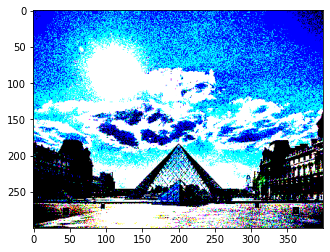

In [33]:
generated_image = generate_noise_image(content_image)
plt.imshow(generated_image[0])

In [34]:
model = load_vgg_model('helper/imagenet-vgg-verydeep-19.mat')

In [35]:

sess.run(model['input'].assign(content_image))

out = model['conv4_2']
a_c  = sess.run(out)
a_g = out

J_content = compute_content_cost(a_c, a_g)

In [36]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, style_layers)

In [37]:
J = total_cost(J_content, J_style)

In [38]:
train_step = tf.compat.v1.train.AdamOptimizer(2.0).minimize(J)

In [39]:
def model_nn(sess, input_image, num_iteration = 200):
    sess.run(tf.compat.v1.global_variables_initializer())

    sess.run(model['input'].assign(input_image))

    for i in range(num_iteration):
        sess.run(train_step)
        generated_image  = sess.run(model['input'])

        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js) + '\n')

            # save current generated image in the "/output" directory
            save_image("helper/output/" + str(i) + ".png", generated_image)
        # save last generated image
    save_image('helper/output/generated_image.jpg', generated_image)

    return generated_image

Iteration 0 :
total cost = 5047551000.0
content cost = 7865.7334
style cost = 126186810.0

Iteration 20 :
total cost = 944839230.0
content cost = 15239.669
style cost = 23617172.0

Iteration 40 :
total cost = 480202940.0
content cost = 16717.59
style cost = 12000894.0

Iteration 60 :
total cost = 310084600.0
content cost = 17451.436
style cost = 7747752.0

Iteration 80 :
total cost = 226060770.0
content cost = 17853.428
style cost = 5647056.0

Iteration 100 :
total cost = 178581840.0
content cost = 18158.44
style cost = 4460006.5

Iteration 120 :
total cost = 147726220.0
content cost = 18386.994
style cost = 3688558.8

Iteration 140 :
total cost = 125898080.0
content cost = 18582.557
style cost = 3142806.5

Iteration 160 :
total cost = 109451350.0
content cost = 18733.64
style cost = 2731600.5

Iteration 180 :
total cost = 96550820.0
content cost = 18858.416
style cost = 2409055.8



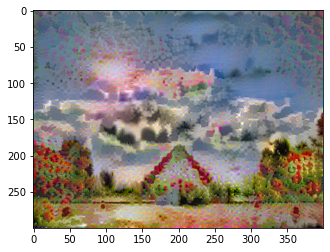

In [40]:
generated_image = model_nn(sess, generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


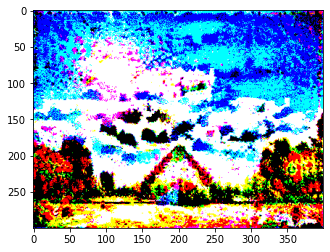

In [41]:
plt.imshow(generated_image.reshape((300,400,3)))